In [7]:
# !pip install --user gensim
# !pip install psycopg2
# !pip install wordcloud
# !pip install --user pyldavis

<a class="anchor" id="toc"></a>

# Table of Contents

## Getting the Data Ready
[Download data](#data_download)

[EDA](#EDA)

[Text Preprocessing](#text_process)
 * [Compound Words for dishes](#compound) 
 * [Restaurant-level Processing](#collapse)  - [load/save df](#df_save)
 * [Merge restaurant and menu](#merge)

## Modeling
[Load joined df](#load_joined)

[Dimension Reduction](#dim_reduce)
* [Exploring LSA - Cuisines](#lsa_cuisine)
* [Exploring LSA - Dishes](#lsa_dishes)
* [LDA (cuisines) & PyLDAvis](#lda_cuisines)
* [LDA (dishes) & PyLDAvis](#lda_dishes)

[Clustering](#cluster)
* [DBSCAN](#dbscan)
* [MeanShift](#meanshift)
* [KMeans](#kmeans)
* [Hierarchical](#hierachy)

## Saving
[Save final clustering](#save_final)

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import chain
import pickle
import string
import collections
import re
import json
import ast
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.manifold import TSNE
import pyLDAvis
import pyLDAvis.gensim
from gensim import corpora, models, similarities, matutils
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gensim/corpora/dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


<a class="anchor" id="data_download"></a>

## Download Data

[Table of Contents](#toc)

In [150]:
import sys
try:
    import psycopg2 as pg
except ImportError:
    print("You should install psycopg2 with the command")
    print("  conda install psycopg2")
    sys.exit(0)

In [151]:
connection_args = {
#     'host': "54.153.84.135",  # You'll have to update this to your IP
    'host': 'localhost',
    'user': 'postgres',  # username
    'password': 'vF_7gjg>n9.a"F(PS\'#YjaWDz,mz]=4XJUT5Tr(Z2FVx\'+WMQs',
    'dbname': 'grubhub',  # DB that we are connecting to
    'port': 5432  # port we opened on AWS
}

In [152]:
connection = pg.connect(**connection_args)

cursor = connection.cursor()

#### Getting restaurant data

In [153]:
# making sure there are no duplicates, and business is not a chain
cursor.execute("SELECT * FROM (SELECT ROW_NUMBER() OVER(PARTITION BY restaurant_id) AS row_num,* FROM restaurant) \
                a WHERE row_num = 1 AND brand_id is null")

In [154]:
df_rest = pd.DataFrame(cursor.fetchall())

In [155]:
len(df_rest)

34027

In [156]:
df_rest.columns =['row_number','index','restaurant_id','name','restaurant_hash','faceted_rating_data','logo','description',
                 'billing_comment','pickup boolean','delivery boolean','ratings' ,'delivery_fee','service_fee',
                 'delivery_minimum','total_menu_items','cuisines' ,'phone_only','phone_number','routing_number',
                 'track_your_grub','accepts_credit','accepts_cash','address','time_zone','price_rating',
                 'min_delivery_fee','min_delivery_fee_without_discounts','restaurant_cdn_image_url',
                 'media_image','merchant_url_path','score','new_restaurant','brand_name','brand_id','chain_id',
                 'available_promo_codes','percentage_ad_fee','vendor_location_id','catering']

#### Getting Json data for restaurants

In [157]:
turn_json = ['faceted_rating_data','ratings','delivery_minimum','phone_number','routing_number','address','min_delivery_fee',
'media_image']

for j in turn_json:
    df_rest[j] = df_rest[j].apply(lambda x: ast.literal_eval(x))

In [158]:
# getting rating count, value and city
df_rest['rating_count'] = df_rest['ratings'].apply(lambda x: x['rating_count'])
df_rest['rating_value'] = df_rest['ratings'].apply(lambda x: x['actual_rating_value'])
df_rest['city'] = df_rest['address'].apply(lambda x: x['address_locality'])

In [159]:
df_rest['long'] = df_rest['address'].apply(lambda x: x['longitude'])
df_rest['lat'] = df_rest['address'].apply(lambda x: x['latitude'])

In [84]:
imp_rest = df_rest[['restaurant_id', 'name', 'total_menu_items','cuisines','rating_count','rating_value','city',
                    'price_rating']]

#### Getting menu data

In [85]:
cursor.execute("SELECT * FROM (SELECT ROW_NUMBER() OVER(PARTITION BY restaurant_id, id) AS row_num, * \
                FROM menu WHERE popular = 't' and deleted = 'f') a WHERE row_num = 1")

In [86]:
df_menu = pd.DataFrame(cursor.fetchall())

In [87]:
len(df_menu)

153776

In [16]:
df_menu.columns = ['row_num','index','uuid', 'id','restaurant_id','merchant_uuid', 'menu_category_name','name',
                   'description','price','media_image','dishes','allowable_order_types','menu_item_features',
                   'item_coupon','popular','deleted']

since there are some restaurants that sell not just food (restaurant_id = 287827 sells toilet paper), we remove menu dthat does not have dishes

In [17]:
df_rest[df_rest['restaurant_id']==287827]

,row_number,index,restaurant_id,name,restaurant_hash,faceted_rating_data,logo,description,billing_comment,pickup boolean,...,chain_id,available_promo_codes,percentage_ad_fee,vendor_location_id,catering,rating_count,rating_value,city,long,lat
4486,1,7,287827,Freshco Grocery and Deli,5984ce8ad2a7303fd13e5b58c698ca3c,"{'review_data': {'total_count': 191, 'valid_co...",https://media-cdn.grubhub.com/image/upload/v15...,None,Stanton St,True,...,None,None,0.0,31490.0,False,2789.0,4.164052,New York,-73.98811,40.72134


In [18]:
df_menu[df_menu['dishes'].isna() == True].head(2)

,row_num,index,uuid,id,restaurant_id,merchant_uuid,menu_category_name,name,description,price,media_image,dishes,allowable_order_types,menu_item_features,item_coupon,popular,deleted
26,1,36,uJZOIIVDEeaMJYsU8O4blQ,9920648,194,8lG6sIBqEeaf1avwO2f_3w,Main Entrees,Palak Paneer,Fresh organic spinach and pan-seared vegan che...,"{'amount': 1200, 'currency': 'USD'}",{'base_url': 'https://media-cdn.grubhub.com/im...,None,['standard'],[],False,True,False
43,1,58,D0QTkaSsEei_ocGyUvbWeA,35108640,250,ZsRFUHVuEeaY3_l3FpLaKw,Curries,Chicken Pad Ped Curry,Red hot curry chicken. Classic chicken curry c...,"{'amount': 1125, 'currency': 'USD'}",None,None,"['standard', 'group']",[],False,True,False


<a class="anchor" id="EDA"></a>

## Data Exploration

[Table of Contents](#toc)

In [19]:
imp_rest[['price_rating','name']][imp_rest['price_rating'] == 1].head()

,price_rating,name
39,1.0,Armand's Restaurant & Lounge
44,1.0,Stadium Sports Club & Pizza
47,1.0,Edwardo's Natural Pizza
50,1.0,New York Pizza
57,1.0,Columbus Gourmet Food


Looking at price rating distribution

In [20]:
imp_rest['price_rating'].value_counts()

2.0    15872
3.0     8955
0.0     5067
1.0     3779
4.0      354
Name: price_rating, dtype: int64

Analyzing cuisines

In [21]:
imp_rest['cuisines'] = imp_rest['cuisines'].str.replace('[','').str.replace(']','')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
# foods = []
cuisines = defaultdict(int)

for rows in imp_rest['cuisines']:
    for food in rows.split(","):
        food_c = re.sub(r'[^\w]', ' ', food)
        food_c = food_c.strip()
        cuisines[food_c] += 1

print(f'number of unique cuisines is {len(cuisines)}')

number of unique cuisines is 163


There are a lot of cuisines, and a lot of lunch specials which seem pretty generic. 

In [23]:
sorted_x = sorted(cuisines.items(), key=lambda kv: kv[1], reverse=True)

collections.OrderedDict(sorted_x)

OrderedDict([('Lunch Specials', 15350),
             ('Sandwiches', 9596),
             ('Asian', 7268),
             ('Salads', 6839),
             ('Breakfast', 5949),
             ('Pizza', 5247),
             ('American', 4491),
             ('Seafood', 3743),
             ('Hamburgers', 3624),
             ('Mexican', 3201),
             ('Pasta', 3087),
             ('Healthy', 3027),
             ('Chinese', 2998),
             ('Vegetarian', 2750),
             ('Chicken', 2662),
             ('Dessert', 2643),
             ('Soup', 2481),
             ('Italian', 2305),
             ('Sushi', 2205),
             ('Japanese', 2198),
             ('Noodles', 2027),
             ('Wraps', 1910),
             ('Thai', 1861),
             ('Coffee and Tea', 1844),
             ('Wings', 1667),
             ('Smoothies and Juices', 1664),
             ('Indian', 1610),
             ('Latin American', 1610),
             ('Mediterranean', 1587),
             ('Deli', 1073),
         

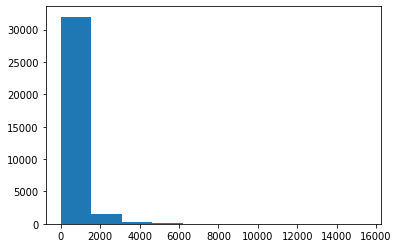

In [24]:
# long tail popularity
plt.hist(df_rest['rating_count']);

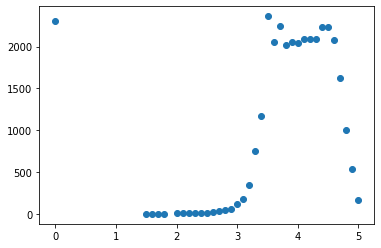

In [25]:
# there seems to be a bunch with zero valuesm and others distributed around 3.2 and 4.8
round(imp_rest['rating_value'],1).value_counts()[::1]

rating_dist = round(imp_rest['rating_value'],1).value_counts().reset_index()
plt.scatter(rating_dist['index'],rating_dist['rating_value']);

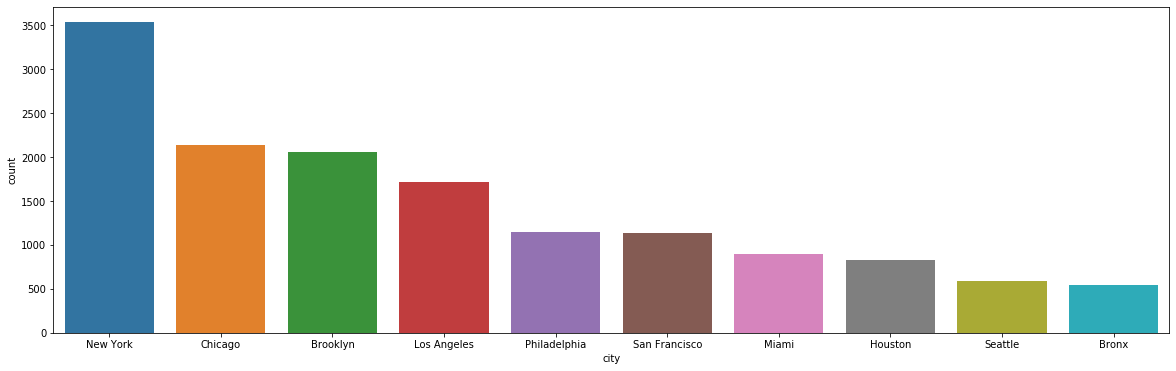

In [26]:
f, ax = plt.subplots(figsize=(20,6))
plot_city = imp_rest['city'].value_counts().reset_index()[:10]
plot_city.columns = ['city','count']

sns.barplot(plot_city['city'],plot_city['count']);

<a class="anchor" id="text_process"></a>

## Text Processing

[Table of Contents](#toc)

<a class="anchor" id="compound"></a>

### Transform dishes to Compound words

#### make compound words of hashtage ('dishes)'

In [27]:
# expanding to compound the words
df_menu['dishes'] = df_menu['dishes'].str.replace("[","").str.replace("]","")
dish_expand = df_menu['dishes'].str.split(",", expand=True)
dish_expand.head(2)

,0,1,2,3,4,5,6,7,8,9
0,'beef sandwiches','sandwiches',None,None,None,None,None,None,None,None
1,'beef sandwiches','sandwiches',None,None,None,None,None,None,None,None


In [28]:
# compounding the words
for i in dish_expand.columns:
    dish_expand[i] = dish_expand[i].str.split(" ").str.join("_")
    dish_expand[i] = [str(x).replace("_\'","").replace("\'","") if x is not None else None for x in dish_expand[i]]

In [29]:
# collapsing to one column
dish_clean = dish_expand[0].fillna('') + ' ' + dish_expand[1].fillna('') + ' ' + dish_expand[2].fillna('') + ' ' +\
            dish_expand[3].fillna('') + ' '  + dish_expand[4].fillna('') + ' ' + dish_expand[5].fillna('') + ' ' + \
            dish_expand[6].fillna('') + ' ' + dish_expand[7].fillna('') + ' ' + dish_expand[8].fillna('') + ' ' + \
            dish_expand[9].fillna('')

dish_clean = pd.DataFrame(dish_clean)
dish_clean.columns = ['dish_compound']

# clean up the nulls
dish_clean['dish_compound'].apply(lambda x: len(x.strip()))

dish_clean.head(2)

,dish_compound
0,beef_sandwiches sandwiches
1,beef_sandwiches sandwiches


In [30]:
df_menu = pd.concat([df_menu,dish_clean],axis=1)

#### remove numbers, capital letters and punctuation

In [31]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', str(x))
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', str(x).lower())

df_menu['description'] = df_menu.description.map(alphanumeric).map(punc_lower)
df_menu['name'] = df_menu['name'].map(alphanumeric).map(punc_lower)
df_menu['menu_category_name'] = df_menu['menu_category_name'].map(alphanumeric).map(punc_lower)

#### combine menu_category_name, name, description and dishes into array of words

In [32]:
word_analyze = df_menu['menu_category_name'].fillna('') + ' ' + df_menu['name'] + ' ' + \
                df_menu['description'].fillna('') + ' ' + df_menu['dish_compound'].fillna('')

word_analyze = pd.DataFrame(word_analyze)
word_analyze.columns = ['words_to_analyze']

In [33]:
df_menu = pd.concat([df_menu,word_analyze],axis=1)

<a class="anchor" id="collapse"></a>

### Restaurant-level Processing

#### Collapsing words in menu to analyze by restaurant

Since we plan to have restaurant as a document, we want to collapse information in menu to feed to our menu. 
Important features are: 
* dishes (dish compound field) combined
* most expensive item in the menu (as an indicator of price)
* number of top items in the menu
* getting count of unique dish hashtags
* count of unique dish sets (e.g. chicken, chicken kebab hashtags for two dishes will count as 1 unique dish sets)
* total words to analyze combined (but will not be used for now)

In [231]:
df_menu.head(2)

,row_num,index,uuid,id,restaurant_id,merchant_uuid,menu_category_name,name,description,price,...,dishes,allowable_order_types,menu_item_features,item_coupon,popular,deleted,dish_compound,words_to_analyze,price_amt,currency
0,1,33,eqNOslqCEeaRxfuKZf6fTA,15190959,188,eF0TsHiIEeaxeV0pJr4qQw,al s italian beef,regular beef sandwich,none,"{'amount': 735, 'currency': 'USD'}",...,"'beef sandwiches', 'sandwiches'","['group', 'standard']",[],False,True,False,beef_sandwiches sandwiches,beef_sandwiches sandwiches,735,USD
1,1,34,eqzroFqCEea-wsHpmIQDtw,15190960,188,eF0TsHiIEeaxeV0pJr4qQw,al s italian beef,big beef sandwich,none,"{'amount': 975, 'currency': 'USD'}",...,"'beef sandwiches', 'sandwiches'","['group', 'standard']",[],False,True,False,beef_sandwiches sandwiches,beef_sandwiches sandwiches,975,USD


<a class="anchor" id="df_save"></a>

In [34]:
with open('df_menu.pickle', 'wb') as to_write:
    pickle.dump(df_menu, to_write)
    
with open('df_rest.pickle', 'wb') as to_write:
    pickle.dump(df_rest, to_write)

In [22]:
with open('df_menu.pickle','rb') as read_file:
    df_menu = pickle.load(read_file)
    
with open('df_rest.pickle','rb') as read_file:
    df_rest = pickle.load(read_file)

In [ ]:
# Getting a view of the first five restaurants

In [40]:
pd.set_option('max_colwidth', 600)
df_rest[['name', 'cuisines']][:5]


,name,cuisines
0,Al's Italian Beef,"['American', 'Hamburgers', 'Hot Dogs', 'Lunch Specials', 'Salads', 'Sandwiches']"
1,Amarit Thai & Sushi,"['Asian', 'Lunch Specials', 'Sushi', 'Thai']"
2,Andies,"['Alcohol', 'Chicken', 'Greek', 'Gyro', 'Hamburgers', 'Healthy', 'Mediterranean', 'Middle Eastern', 'Sandwiches', 'Seafood', 'Vegan', 'Vegetarian']"
3,Arya Bhavan,"['Gluten-Free', 'Healthy', 'Indian', 'Lunch Specials', 'Middle Eastern', 'Organic', 'Vegan', 'Vegetarian']"
4,Connie's Pizza (Archer Ave),"['American', 'Italian', 'Lunch Specials', 'Pasta', 'Pizza', 'Sandwiches']"


[Table of Contents](#toc)

#### Getting item price in menu (as indicator of price)

In [36]:
df_menu['price'] = df_menu['price'].apply(lambda x: json.loads(str(x).replace("\'", "\"")) if x is not None else None)
df_menu['media_image'] = df_menu['media_image'].apply(lambda x: json.loads(str(x).replace("\'", "\"")) if x is not None else None)

In [37]:
df_menu['price_amt'] = df_menu['price'].apply(lambda x: x['amount'])
df_menu['currency'] = df_menu['price'].apply(lambda x: x['currency'])


#### Collapsing information at restaurant level

Collapsing dishes

In [38]:
# cleaning the white space
df_menu['dish_compound'] = df_menu['dish_compound'].apply(lambda x: x.strip())

# collapsing dish
dish_collapsed = pd.DataFrame(df_menu.groupby('restaurant_id')['dish_compound'].apply(' '.join)).reset_index()

Collapsing all words

In [39]:
# cleaning up white space
df_menu['words_to_analyze'] = df_menu['dish_compound'].apply(lambda x: x.strip())

all_words = pd.DataFrame(df_menu.groupby('restaurant_id')['words_to_analyze'].apply(' '.join)).reset_index()

#### Grouping menu attributes
Getting:
* max price
* count top items

In [40]:
# aggregating restaurant level
menu_collapsed = df_menu.groupby('restaurant_id').agg({'price_amt':'max', 'index':'count','dish_compound':'unique'}).\
            reset_index() 

#### Dish variability
Getting:
* unique dish count
* hashtag count

In [41]:
# getting count of unique dishes
menu_collapsed['unique_dishes'] = menu_collapsed['dish_compound'].apply(lambda x: len(x))


# long-winded way of getting unique hashtag dishes
menu_collapsed['dish_hashtag_count'] = menu_collapsed['dish_compound'].apply(lambda x: len(set(re.sub(r'[^\w]', ' ',str(x)).strip().replace(" ",",").replace(",,,",",").\
                            replace(",,",",").split(","))))

menu_collapsed['dish_hashtag_count'] = menu_collapsed['dish_compound'].apply(lambda x: len(set(re.sub(r'[^\w]', ' ',str(x)).strip().replace(" ",",").replace(",,,",",").\
                            replace(",,",",").split(","))))

menu_collapsed.head(4)

,restaurant_id,price_amt,index,dish_compound,unique_dishes,dish_hashtag_count
0,188,975,5,"[beef_sandwiches sandwiches, appetizers fries]",2,4
1,190,1150,10,"[appetizers crab_rangoon crab_rangoon rangoon,...",10,25
2,191,1495,10,"[classic_sandwiches sandwiches, hummus, appeti...",9,14
3,194,1200,4,[bread_varieties garlic_naan indian_breads naa...,4,10


In [42]:
# making sure we can process this later with count vectorizer or TF-IDF
menu_collapsed['dish_compound'] = menu_collapsed['dish_compound'].apply(lambda x: re.sub(r'[^\w]', ' ',str(x)).strip().replace(" ",",").replace(",,,",",").\
                            replace(",,",",").replace(","," "))

menu_collapsed.columns = ['restaurant_id','max_price','count_top_dishes','dish_compound','unique_dishes',\
                          'unique_hashtag_count']

In [43]:
menu_collapsed.head(2)

,restaurant_id,max_price,count_top_dishes,dish_compound,unique_dishes,unique_hashtag_count
0,188,975,5,beef_sandwiches sandwiches appetizers fries,2,4
1,190,1150,10,appetizers crab_rangoon crab_rangoon rangoon a...,10,25


<a class="anchor" id="merge"></a>

### Merging menu and restaurant DFs

[Table of Contents](#toc)

In [44]:
joined_df = df_rest[['cuisines','price_rating','restaurant_id']].merge(menu_collapsed, on = 'restaurant_id',how='inner')

In [45]:
joined_df.head(3)

,cuisines,price_rating,restaurant_id,max_price,count_top_dishes,dish_compound,unique_dishes,unique_hashtag_count
0,"['American', 'Hamburgers', 'Hot Dogs', 'Lunch ...",2.0,188,975,5,beef_sandwiches sandwiches appetizers fries,2,4
1,"['Asian', 'Lunch Specials', 'Sushi', 'Thai']",2.0,190,1150,10,appetizers crab_rangoon crab_rangoon rangoon a...,10,25
2,"['Alcohol', 'Chicken', 'Greek', 'Gyro', 'Hambu...",3.0,191,1495,10,classic_sandwiches sandwiches hummus appetizer...,9,14


In [46]:
for i in joined_df['cuisines']:
    print(type(i))
    break
#     type(joined_df['cuisines'])

<class 'str'>


In [47]:
joined_df['cuisines'] = joined_df['cuisines'].map(lambda x: x.replace("'Lunch Specials', ","").replace(",'Lunch Specials'",""))

We are now at 163 unique cuisines

In [48]:
# foods = []
cuisines = defaultdict(int)

for rows in joined_df['cuisines']:
    for food in rows.split(","):
        food_c = re.sub(r'[^\w]', ' ', food)
        food_c = food_c.strip()
        cuisines[food_c] += 1

print(f'number of unique cuisines is {len(cuisines)}')

number of unique cuisines is 163


### Clean / tokenize some columns first

<a class="anchor" id="load_joined"></a>

In [49]:
with open('joined_df.pickle', 'wb') as to_write:
    pickle.dump(joined_df, to_write)

In [3]:
with open('joined_df.pickle','rb') as read_file:
    joined_df = pickle.load(read_file)

## Modelling

[Table of Contents](#toc)

The approach here is to combine some ordinal and numerical data with NLP when performing clustering. Because there are 163 unique cuisines for our dataset, and many unique types of dishes we will do dimension reduction on cuisines and dish_compound. Then we can combine the reduced dimensions to the ordinal and numerical data.

Feature input: 
* Ordinal: price rating
* Numerical: max_price, count_top_dishes, unique_dishes, unique_hashtag_count
* Reduced to N dimensions: cuisines
* Reduced to N dimensions: dish_compound

<a class="anchor" id="dim_reduce"></a>

## Dimension Reduction

###  Defining some Functions

In [3]:
def count_vect(dataframe):
    """
    input: cleaned pd.series 
    output: vectorized word
    """
    vectorizer = CountVectorizer()
    doc_word = vectorizer.fit_transform(dataframe)
    return doc_word

In [4]:
def tfidf_process(dataframe):
    """
    input: cleaned pd.series 
    output: TF-IDF word
    """
    tfidf1 = TfidfVectorizer()
    doc_word = tfidf1.fit_transform(dataframe)
    return doc_word

In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
def reduce_dimension(doc_word, dim_red, n_topics, topic):
    '''
    input: 
    - series vectorized
    - dimensions reduction technique: TruncatedSVD, NMF
    - n_topics to reduce dimensions to
    - topic: is it cuisines, or dishes or whatever!
    return: reduced dimensions and values
    '''
    model = dim_red(n_topics)
    
    doc_topic = model.fit_transform(doc_word)

    comp_set = []
    for i in range(1,n_topics+1):
        comp_set.append(topic + "_dim_" + str(i))
        
    Vt = pd.DataFrame(doc_topic.round(5),
             columns = comp_set)
    
#     print(model.explained_variance_ratio_)
    return Vt

<a class="anchor" id="lsa_cuisines"></a>

## Exploring LSA - Cuisines

#### Compound and process words in cuisines

In [8]:
clean_cuisines = joined_df['cuisines'].str.replace("', '",",").str.replace(" ","_")
clean_cuisines.head(2)

0    ['American,Hamburgers,Hot_Dogs,Salads,Sandwich...
1                                 ['Asian,Sushi,Thai']
Name: cuisines, dtype: object

In [9]:
# run count vectorizer
vectorizer = CountVectorizer()
doc_word = vectorizer.fit_transform(clean_cuisines)
doc_word.shape

(28436, 164)

In [10]:
# vectorizer = TfidfVectorizer()
# doc_word = vectorizer.fit_transform(clean_cuisines)

[Table of Content](#toc)

In [11]:
pd.DataFrame(doc_word.toarray(), index=clean_cuisines,columns=vectorizer.get_feature_names()).head(2)

,afghan,african,albanian,alcohol,american,argentinian,asian,asian_fusion,australian,austrian,...,turkish,ukrainian,vegan,vegetarian,venezuelan,vietnamese,waffles,wings,wraps,yemeni
cuisines,,,,,,,,,,,,,,,,,,,,,
"['American,Hamburgers,Hot_Dogs,Salads,Sandwiches']",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"['Asian,Sushi,Thai']",0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Deciding how many number of components to take for cuisines using LSA

In [13]:
num_components = 100
lsa = TruncatedSVD(num_components)
doc_topic = lsa.fit_transform(doc_word)

lsa_score = defaultdict(int)

# lsa_score = defaultdic(int)
lsa_score[0] = lsa.explained_variance_ratio_[0]

for i in range(1,num_components):
    lsa_score[i] = lsa.explained_variance_ratio_[i] + lsa_score[i-1]

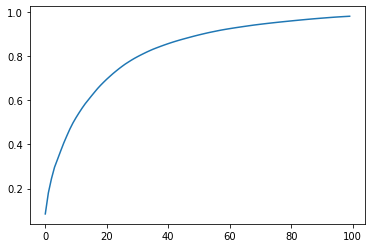

In [14]:
plt.plot(list(lsa_score.values()))

In [15]:
# if we stop at 23 dimensions, we can explain 73% of the variance
lsa_score[23]

0.7325433142669427

In [16]:
topic_word = pd.DataFrame(lsa.components_.round(3), index = ['component_' + str(i + 1) for i in range(num_components)],
#              index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = vectorizer.get_feature_names())
topic_word.loc[:'component_23',:]

,afghan,african,albanian,alcohol,american,argentinian,asian,asian_fusion,australian,austrian,...,turkish,ukrainian,vegan,vegetarian,venezuelan,vietnamese,waffles,wings,wraps,yemeni
component_1,0.000,0.001,0.000,0.005,0.245,0.001,0.120,0.003,0.000,0.000,...,0.004,0.0,0.040,0.118,0.001,0.013,0.002,0.091,0.135,0.0
component_2,0.000,0.001,-0.000,0.000,-0.078,-0.000,0.731,0.012,-0.000,-0.000,...,0.001,0.0,0.024,0.135,-0.000,0.045,-0.000,-0.007,-0.030,-0.0
component_3,0.000,0.002,-0.000,0.003,-0.007,-0.000,-0.105,-0.001,0.000,0.000,...,0.003,0.0,0.043,0.116,0.002,-0.000,0.004,-0.073,0.046,0.0
component_4,0.002,0.005,0.000,0.001,-0.198,0.000,-0.255,0.000,0.000,-0.000,...,0.011,0.0,0.113,0.406,0.001,-0.013,-0.001,0.039,0.025,-0.0
component_5,0.000,0.002,-0.000,0.001,0.131,0.003,-0.018,-0.002,-0.000,-0.000,...,-0.005,0.0,0.009,0.056,0.001,-0.012,0.002,0.009,-0.070,-0.0
component_6,0.001,0.003,0.000,-0.001,0.559,-0.002,-0.046,0.000,0.000,-0.000,...,-0.002,-0.0,-0.008,0.067,-0.001,-0.003,-0.002,0.163,-0.012,0.0
component_7,-0.001,-0.003,0.000,-0.004,0.021,0.001,-0.054,0.005,-0.000,-0.000,...,-0.005,0.0,-0.144,-0.371,0.001,-0.016,0.000,0.066,-0.018,-0.0
component_8,-0.000,0.000,-0.000,0.002,0.320,-0.002,-0.034,0.002,0.000,-0.000,...,0.000,-0.0,0.067,0.165,0.000,-0.033,-0.000,0.011,0.020,-0.0
component_9,0.000,-0.000,-0.000,0.000,0.313,-0.001,0.045,-0.001,-0.000,-0.000,...,-0.002,0.0,0.008,-0.063,-0.001,-0.024,0.002,-0.022,0.083,-0.0
component_10,0.001,-0.001,0.000,-0.002,-0.134,0.001,0.072,-0.001,-0.000,0.000,...,0.001,-0.0,0.030,0.095,0.003,0.006,-0.006,0.008,0.008,0.0


In [17]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [18]:
display_topics(lsa, vectorizer.get_feature_names(), 5)


Topic  0
sandwiches, salads, breakfast, pizza, american

Topic  1
asian, chinese, japanese, sushi, noodles

Topic  2
breakfast, mexican, healthy, coffee_and_tea, smoothies_and_juices

Topic  3
vegetarian, healthy, salads, seafood, soup

Topic  4
mexican, breakfast, pizza, pasta, italian

Topic  5
american, hamburgers, chicken, seafood, wings

Topic  6
seafood, salads, mexican, soup, chicken

Topic  7
sushi, japanese, american, healthy, vegetarian

Topic  8
salads, american, lunch_specials, hamburgers, chinese

Topic  9
mexican, sandwiches, tacos, latin_american, hamburgers

Topic  10
lunch_specials, chicken, dessert, japanese, sushi

Topic  11
dessert, hamburgers, coffee_and_tea, wings, chicken

Topic  12
american, dessert, sandwiches, mexican, lunch_specials

Topic  13
chicken, wings, pizza, breakfast, mediterranean

Topic  14
soup, chinese, noodles, japanese, sushi

Topic  15
wraps, mediterranean, chinese, smoothies_and_juices, pizza

Topic  16
mediterranean, soup, indian, middle_ea

In [19]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = clean_cuisines.index,
             columns = ['component_' + str(i + 1) for i in range(num_components)])
Vt.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,1.48661,-0.34009,0.16087,-0.34091,-0.67235,0.69349,0.28318,0.22153,0.50534,0.31579,...,-0.00646,-0.01787,0.00066,-0.00052,0.00786,0.00363,0.01056,0.00125,-0.00676,0.00003
1,0.18786,1.14312,-0.17750,-0.38777,-0.16901,-0.24148,0.06395,0.39736,-0.04639,0.01479,...,0.00185,-0.00153,0.00020,0.00113,-0.00187,-0.00012,-0.00063,0.00039,0.00031,-0.00042
2,1.45484,0.27376,0.61462,1.11739,-0.18863,0.99404,-0.60908,0.30704,-0.95501,0.31068,...,-0.02142,0.02059,-0.01106,-0.01845,-0.05178,0.05630,0.16094,0.05353,0.81113,0.01238
3,0.40347,0.34199,0.39126,1.23689,0.15222,0.11249,-1.34463,0.57393,-0.03628,0.29777,...,-0.03021,0.12280,0.02022,-0.21822,-0.13829,-0.00963,-0.04205,-0.03860,0.00298,-0.01921
4,1.38953,-0.49954,-1.18172,-0.40387,0.50083,0.22457,-0.32541,0.16777,-0.22598,-0.11332,...,0.00106,0.00211,-0.00354,0.00223,0.00390,0.00096,-0.00244,-0.00256,-0.00357,0.00591


<a class="anchor" id="lsa_dishes"></a>

## Exploring LSA - Dishes

[Table of Contents](#toc)

In [4]:
dishes = joined_df['dish_compound']

In [5]:
vectorizer = CountVectorizer()
dishes_v = vectorizer.fit_transform(dishes)

# getting doc topic term for dishes
doc_term_dish = pd.DataFrame(dishes_v.toarray(),columns=vectorizer.get_feature_names())

In [6]:
vectorizer = TfidfVectorizer()
dishes_v = vectorizer.fit_transform(dishes)

doc_term_dish = pd.DataFrame(dishes_v.toarray(),columns=vectorizer.get_feature_names())

In [7]:
doc_term_dish.shape

(28436, 2239)

In [8]:
num_components = 200
lsa = TruncatedSVD(num_components)
doc_topic = lsa.fit_transform(doc_term_dish)

lsa_score_dish = defaultdict(int)

# lsa_score = defaultdic(int)
lsa_score_dish[0] = lsa.explained_variance_ratio_[0]

for i in range(1,num_components):
    lsa_score_dish[i] = lsa.explained_variance_ratio_[i] + lsa_score_dish[i-1]

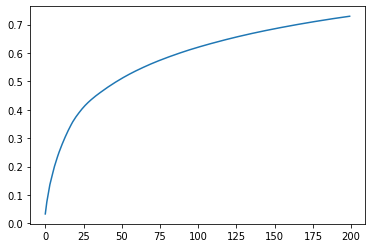

In [9]:
plt.plot(list(lsa_score_dish.values()))


In [10]:
# similarly, looks like components up to 23 explains quite a bit!
lsa_score_dish[23]

0.396388948983626

In [11]:
# display_topics(lsa, vectorizer.get_feature_names(), 5)

<a class="anchor" id="lda_cuisines"></a>

### LDA - cuisines

[Table of Contents](#toc)

In [107]:
lda_cuisines = []
for i in joined_df['cuisines']:
    p = str(i.replace("', '",",").replace(" ","_")).replace("['","").replace("']","")
    p = p.split(",")
    lda_cuisines.append(p)

In [108]:
lda_cuisines[1]

['Asian', 'Sushi', 'Thai']

In [109]:
id2word = corpora.Dictionary(lda_cuisines)

corpus = [id2word.doc2bow(text) for text in lda_cuisines]

In [110]:
lda = models.LdaModel(corpus=corpus, num_topics=30, id2word=id2word, random_state=12)

In [111]:
lda_corpus = lda[corpus]
lda_corpus

In [112]:
lda_docs = [doc for doc in lda_corpus]

In [171]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower is better


Perplexity:  -4.709618866771708


In [172]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=lda_cuisines, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.40737849809790433


In [173]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
vis

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.394510 -0.020913       1        1  7.074811
17     0.135571  0.252272       2        1  6.985334
24     0.226268  0.155919       3        1  5.924227
3      0.247738  0.021976       4        1  5.433795
21    -0.115996  0.075732       5        1  5.146611
20    -0.329370  0.003994       6        1  5.138105
11     0.155102  0.247880       7        1  5.003363
0      0.194731 -0.113771       8        1  4.178836
5      0.083267  0.120418       9        1  4.095394
13     0.070333  0.120199      10        1  4.013516
22    -0.257368  0.067502      11        1  3.815671
25     0.064854 -0.204512      12        1  3.811001
8      0.090274 -0.053323      13        1  3.699737
15     0.182810 -0.057793      14        1  3.432030
29     0.014433  0.179003      15        1  3.194740
10     0.056986 -0.262598      16        1  3.054047
18     0.117367 -0.168513      17        1  2.858146
12    -0.161251 -0.055072      18        1  2.687775
14     0.049862 -0.229938      19        1  2.281606
7     -0.310442  0.077020      20        1  2.239525
2      0.130357 -0.046134      21        1  2.194307
28     0.055955 -0.214491      22        1  1.786032
1     -0.272209 -0.013364      23        1  1.704914
19     0.106822  0.059685      24        1  1.660188
6      0.179589  0.035599      25        1  1.572039
9      0.028612 -0.052945      26        1  1.555813
27     0.154057  0.088055      27        1  1.511322
4      0.087940 -0.044935      28        1  1.403292
23    -0.275945  0.019293      29        1  1.381952
16    -0.315838  0.013755      30        1  1.161873, topic_info=   Category         Freq            Term        Total  loglift  logprob
23  Default  4304.000000           Pizza  4304.000000  30.0000  30.0000
5   Default  4998.000000           Asian  4998.000000  29.0000  29.0000
26  Default  2549.000000         Mexican  2549.000000  28.0000  28.0000
47  Default  2365.000000            Soup  2365.000000  27.0000  27.0000
6   Default  2059.000000           Sushi  2059.000000  26.0000  26.0000
..      ...          ...             ...          ...      ...      ...
38  Topic30     0.125580  Latin_American  1368.596191  -4.8412  -9.1536
50  Topic30     0.082390          Kosher   104.872665  -2.6939  -9.5750
47  Topic30     0.126807            Soup  2365.031738  -5.3785  -9.1438
43  Topic30     0.096568        Calzones   496.788208  -4.0905  -9.4162
19  Topic30     0.108863          Indian  1637.047607  -5.1632  -9.2964

[1827 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
108      28  0.994737   African
8         5  0.975030   Alcohol
0         1  0.000277  American
0         2  0.009961  American
0         3  0.254546  American
...     ...       ...       ...
41       25  0.001439     Wraps
41       26  0.001439     Wraps
41       27  0.000719     Wraps
41       28  0.007912     Wraps
117      30  0.978622        []

[606 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 18, 25, 4, 22, 21, 12, 1, 6, 14, 23, 26, 9, 16, 30, 11, 19, 13, 15, 8, 3, 29, 2, 20, 7, 10, 28, 5, 24, 17])

In [9]:
from pprint import pprint

In [175]:
pprint(lda.print_topics())
# doc_lda = lda[corpus]

[(10,
  '0.602*"Mexican" + 0.118*"Breakfast" + 0.110*"Latin_American" + '
  '0.066*"Spanish" + 0.064*"Seafood" + 0.011*"Salads" + 0.009*"Sandwiches" + '
  '0.008*"American" + 0.002*"Hamburgers" + 0.002*"Healthy"'),
 (15,
  '0.424*"American" + 0.166*"Breakfast" + 0.121*"Diner" + 0.095*"Soul_Food" + '
  '0.067*"Sandwiches" + 0.059*"Seafood" + 0.031*"Salads" + 0.018*"Hamburgers" '
  '+ 0.012*"Pasta" + 0.002*"Italian"'),
 (28,
  '0.227*"Hot_Dogs" + 0.173*"Halal" + 0.115*"Empanadas" + '
  '0.097*"Latin_American" + 0.088*"Fine_Dining" + 0.085*"Colombian" + '
  '0.046*"Dominican" + 0.044*"Breakfast" + 0.038*"Sandwiches" + '
  '0.026*"Hamburgers"'),
 (2,
  '0.192*"Ice_Cream" + 0.176*"Dessert" + 0.131*"Steak" + 0.128*"Shakes" + '
  '0.088*"Crepes" + 0.051*"Hamburgers" + 0.051*"Salads" + 0.047*"Sandwiches" + '
  '0.038*"Smoothies_and_Juices" + 0.025*"Breakfast"'),
 (9,
  '0.501*"Latin_American" + 0.156*"Peruvian" + 0.108*"Tapas" + '
  '0.047*"Sandwiches" + 0.044*"Puerto_Rican" + 0.036*"Russian" 

#### Getting reduced dimensions

In [113]:
cuisine_dim = pd.DataFrame()
for i, row in enumerate(lda[corpus]):
    cuisine_sparse = defaultdict(list)
    for j, (topic_num, prop_topic) in enumerate(row):
        cuisine_sparse[topic_num] = prop_topic
        
    cuisine_dim = cuisine_dim.append(pd.DataFrame(cuisine_sparse, index=[i,]))        
    

In [114]:
cuisine_dim.columns = ['cuisines_dim_' + str(i + 1) for i in range(30)]
cuisine_dim.head(5).T


,0,1,2,3,4
cuisines_dim_1,NaN,NaN,NaN,NaN,NaN
cuisines_dim_2,NaN,NaN,NaN,NaN,NaN
cuisines_dim_3,NaN,NaN,NaN,NaN,NaN
cuisines_dim_4,NaN,NaN,NaN,NaN,NaN
cuisines_dim_5,NaN,NaN,NaN,NaN,NaN
cuisines_dim_6,NaN,NaN,0.245830,NaN,NaN
cuisines_dim_7,NaN,NaN,NaN,NaN,NaN
cuisines_dim_8,NaN,NaN,NaN,NaN,NaN
cuisines_dim_9,NaN,NaN,NaN,0.149027,NaN
cuisines_dim_10,NaN,NaN,NaN,NaN,NaN


#### Getting and understanding of word distribution

In [55]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

cuisine_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=lda_cuisines)


In [56]:
# snapshot of cuisine allocation. this dataframe to concat with final topic modeled 
cuisine_keywords.columns = ['cuisine_dominant_topic','cuisine_perc_contribution', 'cuisine_topic_keywords','cuisine']
cuisine_keywords.head(7)


,cuisine_dominant_topic,cuisine_perc_contribution,cuisine_topic_keywords,cuisine
0,24.0,0.6621,"Hamburgers, Sandwiches, American, Wings, Salad...","[American, Hamburgers, Hot_Dogs, Salads, Sandw..."
1,26.0,0.4224,"Asian, Chinese, Thai, Noodles, Lunch_Specials,...","[Asian, Sushi, Thai]"
2,13.0,0.3704,"Mediterranean, Gyro, Greek, Middle_Eastern, Sa...","[Alcohol, Chicken, Greek, Gyro, Hamburgers, He..."
3,21.0,0.4093,"Bowls, Vegetarian, Healthy, Vegan, Salads, Glu...","[Gluten-Free, Healthy, Indian, Middle_Eastern,..."
4,17.0,0.6548,"Italian, Pizza, Pasta, Salads, Sandwiches, Sub...","[American, Italian, Pasta, Pizza, Sandwiches]"
5,26.0,0.7583,"Asian, Chinese, Thai, Noodles, Lunch_Specials,...","[Asian, Noodles, Thai]"
6,10.0,0.6778,"Mexican, Breakfast, Latin_American, Spanish, S...","[Breakfast, Mexican]"


#### Having a deeper look at each topic

In [57]:
# getting top document for each cuisine type
cuisine_topic_grped = cuisine_keywords.groupby('cuisine_dominant_topic')
cuisines_topic = pd.DataFrame()

for i, grp in cuisine_topic_grped :
    cuisines_topic = pd.concat([cuisines_topic, grp.sort_values(['cuisine_perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)

cuisines_topic.columns = ['cuisine_dominant_topic','top_doc_perc_contr','cuisine_topic_keywords','top_doc_cuisines']
cuisines_topic.head(2)

,cuisine_dominant_topic,top_doc_perc_contr,cuisine_topic_keywords,top_doc_cuisines
475,0.0,0.8619,"Sandwiches, Breakfast, Deli, Bagels, American,...","[American, Bagels, Breakfast, Deli, Sandwiches..."
5227,1.0,0.8389,"Snacks, Cakes, Chinese, Szechwan, Vegetarian, ...","[Asian, Cantonese, Chinese, Mandarin, Szechwan]"


In [58]:
# getting count of restaurants in each topic
topic_counts = cuisine_keywords['cuisine_dominant_topic'].value_counts()

# getting topic contribution
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

cuisine_topic_contribution =  pd.concat([topic_counts, topic_contribution], axis=1).reset_index()
cuisine_topic_contribution.columns = ['cuisine_dominant_topic','cuisine_count_topics','cuisine_topic_contribution']
cuisine_topic_contribution.head(2)
# pd.merge(cuisines_topic,, how='inner',on='cuisine_dominant_topic')

,cuisine_dominant_topic,cuisine_count_topics,cuisine_topic_contribution
0,26.0,3242,0.1140
1,17.0,2170,0.0763


In [59]:
cuisine_topic_info = pd.merge(cuisines_topic,cuisine_topic_contribution,on='cuisine_dominant_topic')
cuisine_topic_info.head(6)

,cuisine_dominant_topic,top_doc_perc_contr,cuisine_topic_keywords,top_doc_cuisines,cuisine_count_topics,cuisine_topic_contribution
0,0.0,0.8619,"Sandwiches, Breakfast, Deli, Bagels, American,...","[American, Bagels, Breakfast, Deli, Sandwiches...",1555,0.0547
1,1.0,0.8389,"Snacks, Cakes, Chinese, Szechwan, Vegetarian, ...","[Asian, Cantonese, Chinese, Mandarin, Szechwan]",211,0.0074
2,2.0,0.8389,"Ice_Cream, Dessert, Steak, Shakes, Crepes, Ham...","[Crepes, Dessert, Hamburgers, Hot_Dogs, Salads]",403,0.0142
3,3.0,0.8792,"Sandwiches, Salads, Breakfast, Wraps, Hamburge...","[American, Breakfast, Coffee_and_Tea, Hamburge...",1557,0.0548
4,4.0,0.8067,"Caribbean, African, Cuban, Sandwiches, Potato,...","[Cuban, Salads, Sandwiches, Seafood]",278,0.0098
5,5.0,0.8619,"Chicken, Wings, Seafood, Sandwiches, Salads, H...","[Bar_Food, Chicken, Dessert, Salads, Sandwiche...",973,0.0342


<a class="anchor" id="lda_dishes"></a>

### LDA - dishes

[Table of Contents](#toc)

Prepare data

In [60]:
dishes = joined_df['dish_compound']

In [66]:
# Splitting text 
def split_text(texts):
    texts_out = []
    for sent in texts.str.split():
        texts_out.append(sent)
    return texts_out

In [67]:
lda_dishes = split_text(dishes)
lda_dishes[:1]

[['beef_sandwiches', 'sandwiches', 'appetizers', 'fries']]

In [68]:
id2word = corpora.Dictionary(lda_dishes)

corpus = [id2word.doc2bow(text) for text in lda_dishes]

In [69]:
# Create lda model
lda = models.LdaModel(corpus=corpus, num_topics=30, id2word=id2word, random_state=12)

In [70]:
lda.get_topics().shape

(30, 2239)

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower is better


Perplexity:  -5.353588725092497


In [190]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=lda_dishes, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5287354735940153


In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word, sort_topics=False)
vis

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.025348 -0.102781       1        1  1.184472
1     -0.149670  0.147472       2        1  1.822370
2     -0.084788  0.001517       3        1  2.583282
3      0.034963 -0.059644       4        1  1.815657
4     -0.126585  0.166919       5        1  8.659310
5      0.272685  0.068610       6        1  2.745142
6     -0.245996  0.106280       7        1  7.830814
7     -0.210175  0.097766       8        1  4.092654
8      0.099233 -0.113340       9        1  3.729122
9     -0.081215 -0.022494      10        1  1.474445
10    -0.286669  0.038206      11        1  9.214171
11     0.197898  0.077035      12        1  2.140944
12     0.018177  0.126036      13        1  2.051581
13     0.119958 -0.080223      14        1  1.104816
14    -0.041156  0.026187      15        1  4.185136
15     0.254242  0.129571      16        1  3.494561
16     0.043384 -0.186672      17        1  5.447193
17    -0.119070 -0.069357      18        1  0.774311
18     0.051235 -0.142980      19        1  2.678324
19     0.224119  0.104959      20        1  2.427771
20     0.189196  0.143867      21        1  2.191279
21     0.051303  0.169605      22        1  1.186435
22    -0.079754  0.024453      23        1  2.149079
23    -0.156142 -0.060243      24        1  5.398724
24    -0.078722 -0.084710      25        1  1.751293
25    -0.195227  0.002438      26        1  4.768784
26     0.193821  0.112032      27        1  2.662752
27     0.033646 -0.288463      28        1  4.573375
28     0.115967 -0.243633      29        1  5.001670
29    -0.019311 -0.088415      30        1  0.860539, topic_info=    Category         Freq            Term         Total  loglift  logprob
54   Default  5308.000000           pizza   5308.000000  30.0000  30.0000
3    Default  6239.000000      sandwiches   6239.000000  29.0000  29.0000
109  Default  3985.000000           sushi   3985.000000  28.0000  28.0000
41   Default  3886.000000       breakfast   3886.000000  27.0000  27.0000
108  Default  3778.000000            maki   3778.000000  26.0000  26.0000
..       ...          ...             ...           ...      ...      ...
116  Topic30    12.317501         burgers   1942.170776  -0.3052  -4.9824
75   Topic30     3.405046           steak    556.476746  -0.3410  -6.2682
39   Topic30     9.986024           soups   3608.428955  -1.1345  -5.1922
0    Topic30    19.656326      appetizers  12327.070312  -1.6858  -4.5150
4    Topic30     8.700622  chicken_dishes   8547.942383  -2.1347  -5.3300

[1353 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1116     24  0.873486     adana_kebab
1122      9  0.615673          ajiaco
698      15  0.952463  al_pastor_taco
692       5  0.940249    alaskan_roll
860       2  0.914091     almond_milk
...     ...       ...             ...
364      22  0.030412      yellowtail
441      19  0.421004          yogurt
441      30  0.477138          yogurt
1043      9  0.777764         zeppole
331      29  0.951634            ziti

[2745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

#### Getting reduced dimensions

In [71]:
dish_dim = pd.DataFrame()
for i, row in enumerate(lda[corpus]):
    dish_sparse = defaultdict(list)
    for j, (topic_num, prop_topic) in enumerate(row):
        dish_sparse[topic_num] = prop_topic
    
    dish_dim = dish_dim.append(pd.DataFrame(dish_sparse, index=[i,]))        
    

In [73]:
dish_dim.columns = ['dishes_dim_' + str(i + 1) for i in range(30)]
dish_dim.head(7).T


,0,1,2,3,4,5,6
dishes_dim_1,0,0,0,0,0,0,0
dishes_dim_2,0,0,0,0,0,0,0
dishes_dim_3,0.341488,0,0.413164,0,0,0,0
dishes_dim_4,0,0.035346,0,0,0,0,0
dishes_dim_5,0,0,0,0,0,0,0
dishes_dim_6,0,0,0,0,0,0,0
dishes_dim_7,0,0.476015,0,0,0,0.953968,0
dishes_dim_8,0,0,0,0,0,0,0
dishes_dim_9,0,0,0,0,0,0,0
dishes_dim_10,0,0,0,0,0,0,0


In [74]:
pprint(lda.print_topics())

Pretty printing has been turned OFF


In [75]:
dishes_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=lda_dishes)
# snapshot of cuisine allocation. this dataframe to concat with final topic modeled 
dishes_keywords.columns = ['dish_dominant_topic','dish_perc_contribution', 'dish_topic_keywords','dishes']
dishes_keywords.head(6)


,dish_dominant_topic,dish_perc_contribution,dish_topic_keywords,dishes
0,11.0,0.4684,"sandwiches, subs, shake, drinks, cheesesteak, ...","[beef_sandwiches, sandwiches, appetizers, fries]"
1,6.0,0.4761,"noodles, appetizers, pad_thai, curries, spring...","[appetizers, crab_rangoon, crab_rangoon, rango..."
2,19.0,0.4180,"sandwiches, hot_sandwiches, burgers, salads, p...","[classic_sandwiches, sandwiches, hummus, appet..."
3,23.0,0.8044,"curries, bread_varieties, indian_breads, naan,...","[bread_varieties, garlic_naan, indian_breads, ..."
4,27.0,0.7548,"pizza, cheese_pizza, salads, meat_pizza, pasta...","[cheese_pizza, pizza, thin_crust_cheese_pizza,..."
5,6.0,0.9540,"noodles, appetizers, pad_thai, curries, spring...","[appetizers, crab_rangoon, crab_rangoon, rango..."


In [76]:
lda.show_topic(17)

[('appetizers', 0.05041361), ('rice_dishes', 0.040967047), ('stir_fry', 0.035650697), ('puffs', 0.03086405), ('rice_entree', 0.030769566), ('garlic_chicken', 0.029584277), ('fried_rice', 0.029039558), ('deep_dish_pizza', 0.028447246), ('noodles', 0.0275419), ('specialty_sandwich', 0.026382495)]

In [77]:
# getting top document for each dish type
dish_topic_grped = dishes_keywords.groupby('dish_dominant_topic')
dish_topic = pd.DataFrame()

for i, grp in dish_topic_grped :
    dish_topic = pd.concat([dish_topic, grp.sort_values(['dish_perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)

dish_topic.columns = ['dish_dominant_topic','top_doc_perc_contr','dish_topic_keywords','top_doc_dish']
dish_topic.head(7)


,dish_dominant_topic,top_doc_perc_contr,dish_topic_keywords,top_doc_dish
1602,0.0,0.9033,"pork_dishes, steak, ribs, chicken_dishes, pork...","[avocado_salads, mixed_green_salads, salads, c..."
7285,1.0,0.8926,"soups, noodle_soup, ramen, appetizers, rice_di...","[noodle_soup, ramen, shoyu_ramen, soups, noodl..."
5231,2.0,0.9256,"appetizers, chicken_dishes, fries, chicken_ent...","[chicken_dishes, chicken_entree, half_chicken,..."
2693,3.0,0.8792,"salads, caesar_salads, chicken_dishes, cobb_sa...","[asian_chicken_salad, chicken_salads, salads, ..."
6600,4.0,0.9724,"sushi, maki, appetizers, tuna, salmon, tuna_ro...","[miso_soup, side_dishes, soups, maki, special_..."
2692,5.0,0.9396,"drinks, soft_drinks, sandwiches, soda, breakfa...","[coffee, drinks, ice_coffee, bottled_soda, dri..."
1677,6.0,0.9678,"noodles, appetizers, pad_thai, curries, spring...","[appetizers, spring_rolls, thai_spring_roll, a..."


In [78]:
# getting count of restaurants in each topic
topic_counts = dish_topic['dish_dominant_topic'].value_counts()

# getting topic contribution
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

dish_topic_contribution =  pd.concat([topic_counts, topic_contribution], axis=1).reset_index()
dish_topic_contribution.columns = ['dish_dominant_topic','dish_count_topics','dish_topic_contribution']
dish_topic_contribution.head(2)

,dish_dominant_topic,dish_count_topics,dish_topic_contribution
0,29.0,1,0.0333
1,28.0,1,0.0333


In [79]:
# pd.merge(cuisines_topic,, how='inner',on='cuisine_dominant_topic')

dish_topic_info = pd.merge(dish_topic,dish_topic_contribution,on='dish_dominant_topic')
dish_topic_info.head(2)

,dish_dominant_topic,top_doc_perc_contr,dish_topic_keywords,top_doc_dish,dish_count_topics,dish_topic_contribution
0,0.0,0.9033,"pork_dishes, steak, ribs, chicken_dishes, pork...","[avocado_salads, mixed_green_salads, salads, c...",1,0.0333
1,1.0,0.8926,"soups, noodle_soup, ramen, appetizers, rice_di...","[noodle_soup, ramen, shoyu_ramen, soups, noodl...",1,0.0333


<a class="anchor" id="cluster"></a>

## Clustering

[Table of Contents](#toc)

#### Combining the dimensions

In [132]:
level2_joined = pd.concat([joined_df, cuisine_dim, dish_dim], axis=1)
level2_joined = level2_joined.fillna(0)

In [133]:
variability = ['count_top_dishes']
price = ['max_price']
cuisines_nlp = ['cuisines_dim_4', 'cuisines_dim_5', 'cuisines_dim_6',
       'cuisines_dim_7', 'cuisines_dim_8', 'cuisines_dim_9', 'cuisines_dim_10',
       'cuisines_dim_11', 'cuisines_dim_12', 'cuisines_dim_13',
       'cuisines_dim_14', 'cuisines_dim_15', 'cuisines_dim_16',
       'cuisines_dim_17', 'cuisines_dim_18', 'cuisines_dim_19',
       'cuisines_dim_20', 'cuisines_dim_21', 'cuisines_dim_22',
       'cuisines_dim_23','cuisines_dim_24','cuisines_dim_25','cuisines_dim_26',
     'cuisines_dim_27','cuisines_dim_28','cuisines_dim_29','cuisines_dim_30']
dish_nlp = ['dishes_dim_1', 'dishes_dim_2', 'dishes_dim_3',
       'dishes_dim_4', 'dishes_dim_5', 'dishes_dim_6', 'dishes_dim_7',
       'dishes_dim_8', 'dishes_dim_9', 'dishes_dim_10', 'dishes_dim_11',
       'dishes_dim_12', 'dishes_dim_13', 'dishes_dim_14', 'dishes_dim_15',
       'dishes_dim_16', 'dishes_dim_17', 'dishes_dim_18', 'dishes_dim_19',
       'dishes_dim_20', 'dishes_dim_21', 'dishes_dim_22', 'dishes_dim_23',
        'dishes_dim_24', 'dishes_dim_25', 'dishes_dim_26', 'dishes_dim_27',
        'dishes_dim_28', 'dishes_dim_29', 'dishes_dim_30']

In [134]:
data = level2_joined[variability + price + cuisines_nlp + dish_nlp]

In [135]:
pd.set_option('display.max_columns', None)
data.head(2)

,count_top_dishes,max_price,cuisines_dim_4,cuisines_dim_5,cuisines_dim_6,cuisines_dim_7,cuisines_dim_8,cuisines_dim_9,cuisines_dim_10,cuisines_dim_11,cuisines_dim_12,cuisines_dim_13,cuisines_dim_14,cuisines_dim_15,cuisines_dim_16,cuisines_dim_17,cuisines_dim_18,cuisines_dim_19,cuisines_dim_20,cuisines_dim_21,cuisines_dim_22,cuisines_dim_23,cuisines_dim_24,cuisines_dim_25,cuisines_dim_26,cuisines_dim_27,cuisines_dim_28,cuisines_dim_29,cuisines_dim_30,dishes_dim_1,dishes_dim_2,dishes_dim_3,dishes_dim_4,dishes_dim_5,dishes_dim_6,dishes_dim_7,dishes_dim_8,dishes_dim_9,dishes_dim_10,dishes_dim_11,dishes_dim_12,dishes_dim_13,dishes_dim_14,dishes_dim_15,dishes_dim_16,dishes_dim_17,dishes_dim_18,dishes_dim_19,dishes_dim_20,dishes_dim_21,dishes_dim_22,dishes_dim_23,dishes_dim_24,dishes_dim_25,dishes_dim_26,dishes_dim_27,dishes_dim_28,dishes_dim_29,dishes_dim_30
0,5,975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.662176,0.0,0.000000,0.0,0.182269,0.0,0,0,0.341488,0,0,0,0,0,0,0,0,0.471844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,1150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343429,0.0,0.0,0.0,0.000000,0.0,0.423238,0.0,0.000000,0.0,0,0,0,0.035346,0,0,0.476015,0,0,0,0.356087,0,0,0,0,0,0,0,0,0,0,0,0.104587,0,0,0,0,0,0,0


<a class="anchor" id="dbscan"></a>

#### DBSCAN

In [118]:
X = StandardScaler().fit_transform(data)

In [119]:
clustering = DBSCAN(eps=.80, min_samples=15).fit(data)

In [120]:
clustering.core_sample_indices_.shape


(5688,)

In [121]:
max(clustering.labels_)

187

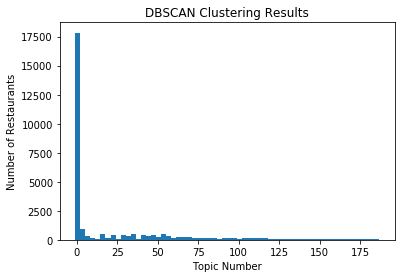

In [122]:
plt.hist(clustering.labels_,bins=60)
plt.xlabel("Topic Number")
plt.ylabel("Number of Restaurants")
plt.title("DBSCAN Clustering Results");

<a class="anchor" id="meanshift"></a>

### Mean Shift


[Table of Contents](#toc)

In [123]:
X = StandardScaler().fit_transform(data)

In [124]:
# estimate bandwidth 
bandwidth = estimate_bandwidth(X, quantile=0.02, n_samples=1500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 197


In [125]:
labels

array([0, 0, 0, ..., 0, 0, 0])

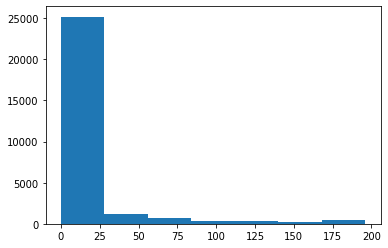

In [126]:
plt.hist(labels, bins=7);

<a class="anchor" id="kmeans"></a>

### k-means

In [137]:
from sklearn.cluster import KMeans

In [141]:
data = level2_joined[variability + cuisines_nlp + price + dish_nlp ]
X = StandardScaler().fit_transform(data)

In [142]:
inertia_set = []

for i in range (15,80):
    km = KMeans(n_clusters=i)
    km.fit(X)
    inertia_set.append(km.inertia_)


In [1]:
plt.plot(np.arange(15,80),inertia_set)

''

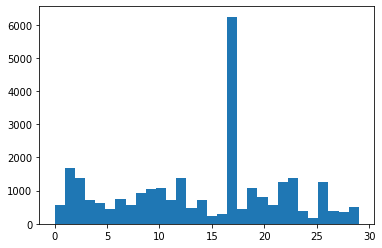

In [143]:
# choosing 30 clusters

num_clusters = 30
km = KMeans(n_clusters=num_clusters, random_state = 42)
km.fit(X)

# let's just try with 30
plt.hist(km.labels_, bins=30)
;


In [145]:
km_label = pd.DataFrame(km.labels_.T)
km_label.columns = ['km_label']
df_km = pd.concat([joined_df,km_label],axis=1)
df_km.head()

,cuisines,price_rating,restaurant_id,max_price,count_top_dishes,dish_compound,unique_dishes,unique_hashtag_count,km_label
0,"['American', 'Hamburgers', 'Hot Dogs', 'Salads...",2.0,188,975,5,beef_sandwiches sandwiches appetizers fries,2,4,23
1,"['Asian', 'Sushi', 'Thai']",2.0,190,1150,10,appetizers crab_rangoon crab_rangoon rangoon a...,10,25,5
2,"['Alcohol', 'Chicken', 'Greek', 'Gyro', 'Hambu...",3.0,191,1495,10,classic_sandwiches sandwiches hummus appetizer...,9,14,4
3,"['Gluten-Free', 'Healthy', 'Indian', 'Middle E...",3.0,194,1200,4,bread_varieties garlic_naan indian_breads naan...,4,10,2
4,"['American', 'Italian', 'Pasta', 'Pizza', 'San...",2.0,240,899,8,cheese_pizza pizza thin_crust_cheese_pizza che...,7,12,0


### Agglomerative clustering 

In [57]:
from sklearn.cluster import AgglomerativeClustering

In [60]:
data = level2_joined[variability + cuisines_nlp + dish_nlp ]

In [ ]:
cllustering = AgglomerativeClustering(linkage='complete', n_clusters=30)
custering.fit(data)

<a class="anchor" id="save_final"></a>

## Save Final Table

[Table of Contents](#toc)

In [193]:
# merging chosen clustering (k-means and dish, cuisine topics)
df_labeled = pd.concat([pd.DataFrame(df_km).drop(['cuisines','dish_compound'],axis=1),dishes_keywords,cuisine_keywords],axis=1)

In [194]:
# merging labeled df with restaurant profile
df_complete = pd.merge(df_rest,df_labeled,how='inner',on='restaurant_id')

In [195]:
# saving two separate dataframes (cuisine and dish)
cuisine_topic_info['cuisine_topic'] = cuisine_topic_info['cuisine_dominant_topic'] + 1

dish_topic_info['dish_topic'] = dish_topic_info['dish_dominant_topic'] + 1

In [196]:
with open('df_complete.pickle', 'wb') as to_write:
    pickle.dump(df_complete, to_write)
    
with open('cuisine_topic_info.pickle', 'wb') as to_write:
    pickle.dump(cuisine_topic_info, to_write)
    
with open('dish_topic_info.pickle', 'wb') as to_write:
    pickle.dump(dish_topic_info, to_write)

In [ ]:
with open('df_complete.pickle','rb') as read_file:
    df_complete = pickle.load(read_file)
    
with open('cuisine_topic_info.pickle','rb') as read_file:
    cuisine_topic_info = pickle.load(read_file)
    
with open('dish_topic_info.pickle','rb') as read_file:
    dish_topic_info = pickle.load(read_file)